# Here is my implemenatation of Hierarchical Clustering (Agglomerative approach).

In [0]:
import numpy as np
import pandas as pd
import math
import random
from scipy.spatial.distance import cdist
from sklearn import cluster, datasets
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
class AgglomerativeHierarchical(object):

  def __init__(self, dataset, n_clusters = 2, distance_threshold = None, linkage='single'):
    if isinstance(dataset, list):
      self.df = dataset
    else:
      self.df = dataset.tolist()

    if n_clusters is None:
      self.n_clusters = None
      self.distance_threshold = distance_threshold
    elif distance_threshold is None:
      self.n_clusters = n_clusters
      self.distance_threshold = None
    elif n_clusters is None and distance_threshold is None:
      raise ValueError("Exactly one of n_clusters and distance_threshold has to be set, and the other needs to be None.")
    elif n_clusters is not None and distance_threshold is not None:
      raise ValueError("Exactly one of n_clusters and distance_threshold has to be set, and the other needs to be None.")


    self.n_clusters = n_clusters
    self.distance_threshold = distance_threshold
    self.final_clusters = {}

    if linkage == 'single' or linkage =="Single":
        self.linkage = self.single_linkage
    elif linkage == 'complete' or linkage == 'Complete':
        self.linkage = self.complete_linkage
    elif linkage == 'average' or linkage == 'Average':
        self.linkage = self.average_linkage
    elif linkage == 'centroid' or linkage == 'Centroid':
        self.linkage = self.centroid_linkage
    else: # not the listed linkage
        raise Exception('Unknown linkage type')

  def single_linkage(self, cluster1, cluster2):
    distances = cdist(cluster1, cluster2, 'euclidean')
    
    return distances.min()
    
  def complete_linkage(self, cluster1, cluster2):
    distances = cdist(cluster1, cluster2, 'euclidean')
    
    return distances.max()

  def average_linkage(self, cluster1, cluster2):
    distances = cdist(cluster1, cluster2, 'euclidean')
    
    return distances.mean()
                
  def centroid_linkage(self, cluster1, cluster2):
    mean1 = np.array(cluster1).mean(axis=0)
    mean2 = np.array(cluster2).mean(axis=0)

    return np.linalg.norm(mean1 - mean2)


  def fit(self):
    clusters = self.__initialize_clusters()
    
    if self.distance_threshold == None:
      current_n_clusters = len(self.df)

      while current_n_clusters > self.n_clusters:
        cluster_distances = self.__count_cluster_distances(clusters)
        closest_clusters = self.__find_clusters_to_merge(cluster_distances)
        clusters = self.__update_clusters(clusters, closest_clusters)
        current_n_clusters = len(clusters)
    
    elif self.n_clusters == None:
      current_min_distance = self.__get_min_distance(clusters)

      while current_min_distance <= self.distance_threshold:
        cluster_distances = self.__count_cluster_distances(clusters)
        closest_clusters = self.__find_clusters_to_merge(cluster_distances)
        clusters = self.__update_clusters(clusters, closest_clusters)
        current_min_distance = self.__get_min_distance(clusters)
        
    # save the final cluster configuration
    self.__set_final_clusters(clusters)

  def __initialize_clusters(self):
    return [[x] for x in self.df]

  def __get_min_distance(self, clusters):
    current_distances = self.__count_cluster_distances(clusters)[0]
    min_index = np.argmin(current_distances)
    min_value = current_distances[min_index]

    return min_value

  def __count_cluster_distances(self, clusters):
    cluster_distances = np.zeros(shape=(len(clusters), len(clusters)))
    
    for i, cluster1 in enumerate(clusters):
      for j, cluster2 in enumerate(clusters):
        if i == j:
          cluster_distances[i][j] = np.inf
        else: # i != j
          cluster_distances[i][j] = self.linkage(np.array(cluster1), np.array(cluster2))

    return cluster_distances

  def __find_clusters_to_merge(self, cluster_distances):
    closest_clusters = np.argmin(cluster_distances, axis=0)
    closest_clusters = [(i, closest_cluster, cluster_distances[i][closest_cluster])
                          for i, closest_cluster in enumerate(closest_clusters)]
    
    closest_clusters.sort(key = lambda closest_clusters: closest_clusters[2])
    
    return closest_clusters

  def __update_clusters(self, clusters, closest_clusters):
    new_clusters = []
    merged_clusters = []
    
    for closest_cluster in closest_clusters:
      if closest_cluster[0] in merged_clusters or closest_cluster[1] in merged_clusters:
        continue
      elif self.distance_threshold is not None and closest_cluster[2] > self.distance_threshold:
        continue
      else:
        new_clusters.append(clusters[closest_cluster[0]] + clusters[closest_cluster[1]])
        merged_clusters.append(closest_cluster[0])
        merged_clusters.append(closest_cluster[1])


    merged_clusters.sort(reverse = True)

    for to_remove in merged_clusters:
      del clusters[to_remove]
    
    return clusters + new_clusters  
    
  def __set_final_clusters(self, final_clusters):
    for i, c in enumerate(final_clusters):
      self.final_clusters[i] = c

    labels = np.full((len(self.df)), -1)
    
    for i, point in enumerate(self.df):
      for key in self.final_clusters.keys():
        if point in self.final_clusters[key]:
         labels[i] = key

    self.cluster_labels = labels

# Testing the implementation.

In [0]:
X, y = datasets.make_blobs(n_samples = 400, centers = 5, cluster_std = 0.60, random_state = 0)

In [0]:
ahc = AgglomerativeHierarchical(dataset = X, n_clusters = 5, distance_threshold = None, linkage = 'single')
ahc.fit()
single_labels = ahc.cluster_labels

In [0]:
ahc = AgglomerativeHierarchical(dataset = X, n_clusters = 5, linkage = 'complete')
ahc.fit()
complete_labels = ahc.cluster_labels

In [0]:
ahc = AgglomerativeHierarchical(dataset = X, n_clusters = 5, linkage = 'average')
ahc.fit()
average_labels = ahc.cluster_labels

In [0]:
ahc = AgglomerativeHierarchical(dataset = X, n_clusters = 5, linkage = 'centroid')
ahc.fit()
centroid_labels = ahc.cluster_labels

Text(0.5, 1.0, 'The True Clusters')

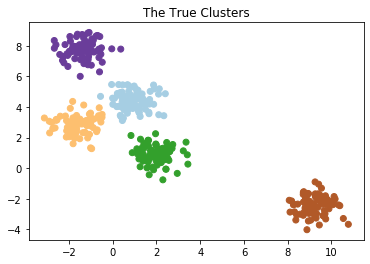

In [8]:
# Plotting the real generated clusters
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired')
plt.title("The True Clusters")

Text(0.5, 1.0, 'My Single AHC')

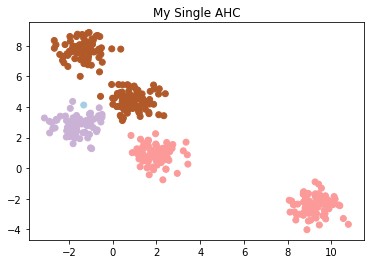

In [9]:
# Plotting the implemented algorithm's clusters, with single linkage
plt.scatter(X[:,0], X[:,1], c=single_labels, cmap='Paired')
plt.title("My Single AHC")

Text(0.5, 1.0, 'My Complete AHC')

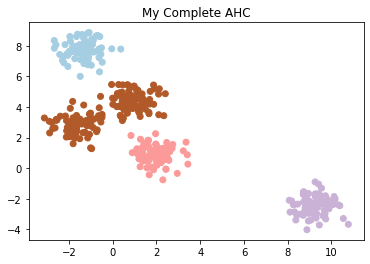

In [10]:
# Plotting the implemented algorithm's clusters, with complete linkage
plt.scatter(X[:,0], X[:,1], c=complete_labels, cmap='Paired')
plt.title("My Complete AHC")

Text(0.5, 1.0, 'My Average AHC')

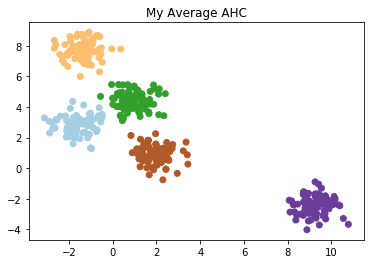

In [11]:
# Plotting the implemented algorithm's clusters, with average linkage
plt.scatter(X[:,0], X[:,1], c=average_labels, cmap='Paired')
plt.title("My Average AHC")

Text(0.5, 1.0, 'My Centroid AHC')

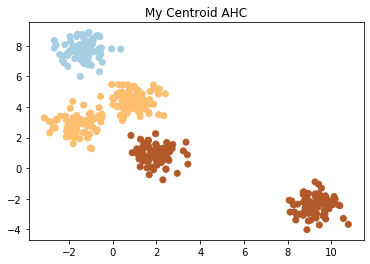

In [12]:
# Plotting the implemented algorithm's clusters, with centroid linkage
plt.scatter(X[:,0], X[:,1], c=centroid_labels, cmap='Paired')
plt.title("My Centroid AHC")

In [13]:
from sklearn.cluster import AgglomerativeClustering

sklearn_ahc = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=5,
                        pooling_func='deprecated')

sklearn_ahc.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=5,
                        pooling_func='deprecated')

Text(0.5, 1.0, 'The sklearn Clusters')

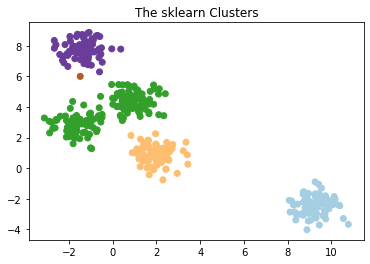

In [14]:
# Plotting sklearn's algorithm's results for comparison
plt.scatter(X[:,0], X[:,1], c=sklearn_ahc.labels_, cmap='Paired')
plt.title("The sklearn Clusters")